In [1]:
from brainiak.funcalign.srm import SRM
import nibabel as nib
from brainiak.io import load_images, load_boolean_mask
from brainiak.image import mask_images, multimask_images
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import nibabel as nib

from brainiak.isc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io

import matplotlib.pyplot as plt

%autosave 10
%matplotlib inline

Autosaving every 10 seconds


Follow the brainiak tutorial:

https://brainiak.org/tutorials/11-SRM/



## Load data

This is a real pickle with brainiak's data io functions, which all kind of have the same name but do different things... Might also do this manually in my actual code.

In [25]:
# get list of nibabel images for some example data
exp_fpaths = ['/data/BnB_USER/oliver/somato/aae961/D1_D5/data.nii.gz',
                '/data/BnB_USER/oliver/somato/ben157/D1_D5/data.nii.gz']
              # '/data/BnB_USER/oliver/somato/clz082/D1_D5/data.nii.gz',
              # '/data/BnB_USER/oliver/somato/cqq680/D1_D5/data.nii.gz']
exp_generator = load_images(exp_fpaths)
exp_nibs = list(exp_generator)
print(exp_nibs)

[<nibabel.nifti1.Nifti1Image object at 0x7f53a6675080>, <nibabel.nifti1.Nifti1Image object at 0x7f53a66752b0>]


In [26]:
# get a list of brain mask arrays. This is a dummy for now since subject 1 mask is simply repeated
s1_mask = load_boolean_mask('/home/homeGlobal/oli/somato/scratch/ica/MELODIC/melodic_wf_workdir/run_lvl/somato_melodic_wf/bet/mapflow/_bet0/data_brain_mask.nii.gz')
dummy_masks = [s1_mask for _ in exp_nibs]

In [68]:
# apply masks to images ... hopefully. Returns generator. 
masked_images = multimask_images(exp_nibs, dummy_masks)

In [70]:
train_data = [element[0] for element in masked_images]

In [71]:
train_data

[array([[ 56.98782349,  52.98867798,  41.99102783, ...,  60.98696899,
          58.98739624,  70.98483276],
        [  0.99978638,   0.99978638,   0.99978638, ...,   0.99978638,
           0.99978638,   0.99978638],
        [ 24.99465942,  25.9944458 ,  29.99359131, ...,  43.99060059,
          34.99252319,  30.99337769],
        ...,
        [964.04401398, 918.05384064, 871.938694  , ..., 924.0525589 ,
         955.04593658, 896.05854034],
        [825.94852066, 890.05982208, 843.94467545, ..., 880.06195831,
         805.95279312, 760.96240616],
        [786.95685196, 751.96432877, 744.96582413, ..., 719.9711647 ,
         707.97372818, 712.97266006]]),
 array([[ 823.0046912 ,  862.95448783,  836.02968572, ...,  864.0237038 ,
          864.99571832,  895.03096688],
        [ 837.97371475,  875.00746784,  825.04592168, ...,  848.95747879,
          791.0254136 ,  844.97221927],
        [1059.98183034, 1010.99229871, 1013.03352919, ...,  983.97029515,
         1000.00853467,  985.039511

# Set up some prior parameters for our SRM

In [29]:
n_iter = 10
n_features = 5

In [30]:
srm = SRM(n_iter=n_iter, features=n_features)

# Fit SRM

In [72]:
srm.fit(train_data)

SRM(comm=<mpi4py.MPI.Intracomm object at 0x7f54dc3937f0>, features=5, n_iter=10,
    rand_seed=0)

# Plot result

SRM: Features X Time-points  (5, 256)


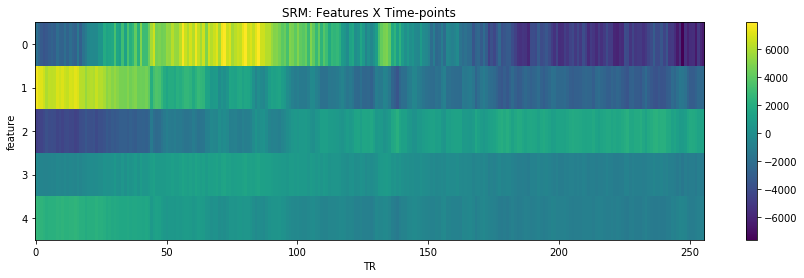

In [78]:
# Plot the shared response
print('SRM: Features X Time-points ', srm.s_.shape)
plt.figure(figsize=(15, 4))
plt.title('SRM: Features X Time-points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.s_, cmap='viridis', aspect='auto')
plt.colorbar();

In [77]:
# you can access the components time courses from srm.s_
# which is an array of shape (n_comps, n_timepoints)
np.shape(srm.s_)

(5, 256)

Plot time course of first component, the one which explains most variance. 

## TODO: We could later take each components time course and determine their frequency power density spectra

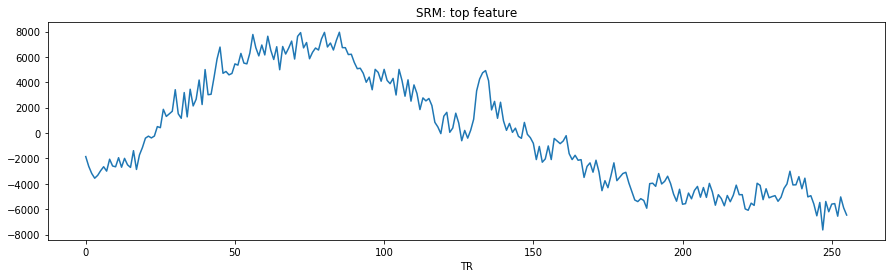

In [79]:
plt.figure(figsize=(15, 4))
plt.title('SRM: top feature')
plt.xlabel('TR')
plt.plot(srm.s_[0, :]);

## Plot similarities of time points

The stimulation cycle could also be visible here. Note that this method considers all components, but we might do the same with the selected ones, which match our cycle.

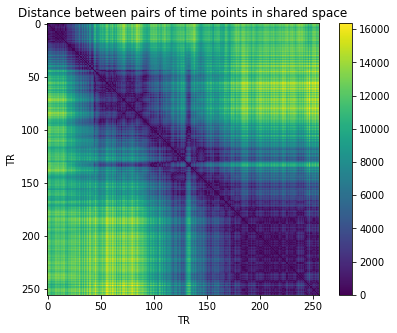

In [80]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure(figsize=(7,5))
plt.title('Distance between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()

## Plot weight matrix

Not sure how we might want to use this ...

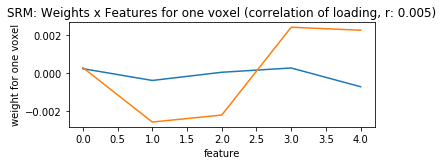

In [81]:
plt.subplot(211)

plt.plot(srm.w_[0][0,:])
plt.plot(srm.w_[1][0,:])
feature_corr = np.corrcoef(srm.w_[0][0,:], srm.w_[1][0,:].T)[0,1]
plt.title('SRM: Weights x Features for one voxel (correlation of loading, r: %0.3f)' % feature_corr) 
plt.xlabel('feature')
plt.ylabel('weight for one voxel')
plt.tight_layout()